In [1]:
#testing

import torch
import torch.nn as nn
import torch.nn.functional as F
from models.networks.basicCoders import BasicDecoderV3

class PeriodicConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(PeriodicConvTranspose2d, self).__init__()
        self.padding = padding
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        # Pad input tensor with periodic boundary conditions
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding), mode='circular')
        # Apply convolution
        x = self.conv(x)
        return x

class sequentialMultiInput(nn.Sequential):
    def forward(self, *inputs):
        for module in self._modules.values():
            if type(inputs) == tuple:
                inputs = module(*inputs)
            else:
                inputs = module(inputs)
        return inputs

class DecoderCNNPBv4_HEMOD(BasicDecoderV3):
    def __init__(self, num_input_nodes, num_output_nodes, output_activation_fct=nn.Identity(), **kwargs):
        super(DecoderCNNPBv4_HEMOD, self).__init__(**kwargs)
        self._output_activation_fct = output_activation_fct
        self.num_input_nodes = num_input_nodes
        self.z = 45
        self.r = 9
        self.phi = 16
        self.hierarchal_outputs = num_output_nodes
        self.output_layers = int(self.hierarchal_outputs / 144)
        
        # self._node_sequence = [(2049, 800), (800, 700), (700, 600), (600, 550), (550, 500), (500, 6480)]
        self._layers =  nn.Sequential(
                   # nn.Unflatten(1, (self._node_sequence[0][0]-1, 1,1)),
                   nn.Unflatten(1, (self.num_input_nodes, 1,1)),

                   PeriodicConvTranspose2d(self.num_input_nodes, 1024, (3,5), 2, 0),
                   nn.BatchNorm2d(1024),
                   nn.PReLU(1024, 0.02),
                   

                   PeriodicConvTranspose2d(1024, 512, (3,5), 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                                   )
        
        self._layers2 = nn.Sequential(
                   PeriodicConvTranspose2d(513, 128, (3,5), 1, 0),
                   nn.BatchNorm2d(128),
                   nn.PReLU(128, 0.02),

                   PeriodicConvTranspose2d(128, self.output_layers, (3,4), 1, 0),
                   # nn.BatchNorm2d(45),
                   nn.PReLU(self.output_layers, 1.0),
                                   )
        
        self._layers3 = nn.Sequential(
                   PeriodicConvTranspose2d(513, 128, (3,5), 1, 0),
                   nn.BatchNorm2d(128),
                   nn.PReLU(128, 0.02),

                   PeriodicConvTranspose2d(128, self.output_layers, (3,4), 1, 0),
                   # nn.BatchNorm2d(45),
                   nn.PReLU(self.output_layers, 0.02),
                                   )
        
    def forward(self, x, x0):
        print("t1: ", x.shape)
        x = self._layers(x)
        print("t2: ", x.shape)
        x0 = self.trans_energy(x0)
        xx0 = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item())), 1)
        x1 = self._layers2(xx0)
        x2 = self._layers3(xx0)
        # need channels * height * width = self.hierarchal_outputs = 1620
        return x1.reshape(x1.shape[0], self.hierarchal_outputs), x2.reshape(x1.shape[0], self.hierarchal_outputs)
    
    def trans_energy(self, x0, log_e_max=14.0, log_e_min=6.0, s_map = 15 * 1.2812657528661318):
        # s_map = max(scaled voxel energy u_i) * (incidence energy / slope of total energy in shower) of the dataset
        return ((torch.log(x0) - log_e_min)/(log_e_max - log_e_min)) * s_map

class DecoderCNNPB_HEv1(BasicDecoderV3):
    def __init__(self, encArch = 'Large', **kwargs):
        self.encArch = encArch
        super(DecoderCNNPB_HEv1, self).__init__(**kwargs)

    def _create_hierarchy_network(self, level: int = 0):
        self.latent_nodes = 2048
        self.layer_step = 11*144
        self.hierarchiel_lvls = 4

        inp_layers = [self.latent_nodes + i * self.layer_step for i in range(self.hierarchiel_lvls)] 
        out_layers = 4 * [self.layer_step]
        out_layers[3] += (6480 - 4 * self.layer_step)

        self.moduleLayers = nn.ModuleList([])
        for i in range(len(inp_layers)):
            self.moduleLayers.append(DecoderCNNPBv4_HEMOD(inp_layers[i], out_layers[i]))
            
        sequential = sequentialMultiInput(*self.moduleLayers)
        return sequential
    
    def forward(self, x, x0):
        self._create_hierarchy_network()
        self.sub_values = []
        x1, x2 = torch.tensor([]), torch.tensor([])
        for lvl in range(self.hierarchiel_lvls):
            cur_net = self.moduleLayers[lvl]
            hits, acts = cur_net(x, x0)
            beta = torch.tensor(self._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
            out.output_activations = self._energy_activation_fct(output_activations) * self._hit_smoothing_dist_mod(output_hits, beta, is_training)
            z = out.output_activations
            self.sub_values.append([hits, acts])
            if lvl == self.hierarchiel_lvls - 1:
                for vals in self.sub_values:
                    x1 = torch.cat((x1, vals[0]), dim=1)
                    x2 = torch.cat((x2, vals[1]), dim=1)
            else:
                x = torch.cat((x, z), dim=1)
        return x1, x2

ModuleNotFoundError: No module named 'models'

In [2]:
class PeriodicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(PeriodicConv2d, self).__init__()
        self.padding = padding
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        # Pad input tensor with periodic boundary conditions
        x = F.pad(x, (self.padding, self.padding, 0, 0), mode='circular')
        # Apply convolution
        x = self.conv(x)
        return x

In [3]:
class PeriodicConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(PeriodicConv3d, self).__init__()
        self.padding = padding
        # try 3x3x3 cubic convolution
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation, groups=groups, bias=bias)
    def forward(self, x):
        # Pad input tensor with periodic boundary and circle-center conditions
        if self.padding == 1:
            mid = x.shape[-1] // 2
            shift = torch.cat((x[..., [-1], mid:], x[..., [-1], :mid]), -1)
            x = torch.cat((x, shift), dim=-2)
        x = F.pad(x, (self.padding, self.padding, 0, 0, 0, 0), mode='circular')
        # Apply convolution
        x = self.conv(x)
        return x

In [171]:
class PeriodicConv3d_v2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(PeriodicConv3d_v2, self).__init__()
        self.padding = padding
        # try 3x3x3 cubic convolution
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation, groups=groups, bias=bias)
    def forward(self, x):
        # Pad input tensor with periodic boundary and circle-center conditions
        if self.padding == 1:
            mid = x.shape[-2] // 2
            shift = torch.cat((x[..., mid:, [0]], x[..., :mid, [0]]), -2)
            x = torch.cat((shift,x), dim=-1)
        x = F.pad(x, (0, 0, self.padding, self.padding, 0, 0), mode='circular')
        # Apply convolution
        x = self.conv(x)
        return x

In [35]:
data = torch.rand([32, 1, 45, 9, 16])
print(data.shape)

torch.Size([32, 1, 45, 9, 16])


In [76]:
# Encoder Conv Testing 
conv1 = nn.Sequential(
    PeriodicConv3d(1, 32, (3,3,3), (2,1,1), 1),
    PeriodicConv3d(32, 64, (3,3,3), (2,1,1), 1),
    # nn.BatchNorm3d(64),
    # nn.PReLU(64, 0.02),
    PeriodicConv3d(64, 128, (3,3,3), (1,1,2), 0),
    PeriodicConv3d(128, 256, (3,3,3), (2,1,2), 0),
    PeriodicConv3d(256, 512, (3,3,3), (1,1,1), 0),
)
# conv2 = PeriodicConv3d(16, 32, 3, 1, 1)
# conv3 = PeriodicConv3d(32, 64, 3, 1, 1)
# xt = conv1(data)
xt = data

print(conv1)
print("Input Shape: ", xt.shape)
for layer in conv1:
    xt = layer(xt)
    print("Cur Shape: ", xt.shape)
    print("Size: ", xt.shape[1] * xt.shape[2] * xt.shape[3] * xt.shape[4])

# xt = conv3(conv2(conv1(data)))
# shape of 3d data (batch_sizes, depth, height, width) 
# width gets padded so 3, 3, 5 in this example
# print(xt.shape)
#torch.Size([32, 128, 29, 1, 8])

Sequential(
  (0): PeriodicConv3d(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 1, 1))
  )
  (1): PeriodicConv3d(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 1, 1))
  )
  (2): PeriodicConv3d(
    (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 2))
  )
  (3): PeriodicConv3d(
    (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 1, 2))
  )
  (4): PeriodicConv3d(
    (conv): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
)
Input Shape:  torch.Size([32, 1, 45, 9, 16])
Cur Shape:  torch.Size([32, 32, 22, 8, 16])
Size:  90112
Cur Shape:  torch.Size([32, 64, 10, 7, 16])
Size:  71680
Cur Shape:  torch.Size([32, 128, 8, 5, 7])
Size:  35840
Cur Shape:  torch.Size([32, 256, 3, 3, 3])
Size:  6912
Cur Shape:  torch.Size([32, 512, 1, 1, 1])
Size:  512


In [40]:
class PeriodicConvTranspose3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, dilation=1, groups=1, bias=True):
        super(PeriodicConvTranspose3d, self).__init__()
        self.padding = padding
        self.conv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        # Pad input tensor with periodic boundary conditions
        if self.padding == 1:
            mid = x.shape[-1] // 2
            shift = torch.cat((x[..., [-1], mid:], x[..., [-1], :mid]), -1)
            x = torch.cat((x, shift), dim=-2)
        x = F.pad(x, (self.padding, self.padding, 0, 0, 0, 0), mode='circular')
        # Apply convolution
        x = self.conv(x)
        return x

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PeriodicConv3d_v2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, 
                 dilation=1, groups=1, bias=True):
        super(PeriodicConv3d_v2, self).__init__()
        self.padding = padding
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, 
                              padding=0, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        # Pad input tensor with periodic boundary conditions
        if self.padding == 1:
            mid = x.shape[-2] // 2
            shift = torch.cat((x[..., mid:, :1], x[..., :mid, :1]), -2)
            x = torch.cat((shift, x), dim=-1)
        x = F.pad(x, (0, 0, self.padding, self.padding, 0, 0), mode='circular')
        x = self.conv(x)
        return x

class PeriodicConvTranspose3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, 
                 output_padding=0, groups=1, bias=True, dilation=1):
        super(PeriodicConvTranspose3d, self).__init__()
        self.padding = padding
        self.conv_transpose = nn.ConvTranspose3d(
            in_channels, out_channels, kernel_size, stride=stride, padding=0,
            output_padding=0, groups=groups, bias=bias, dilation=dilation
        )

    def forward(self, x):
        # Pad input tensor with periodic boundary conditions
        if self.padding == 1:
            mid = x.shape[-2] // 2
            shift = torch.cat((x[..., mid:, :1], x[..., :mid, :1]), -2)
            x = torch.cat((shift, x), dim=-1)
        x = F.pad(x, (0, 0, self.padding, self.padding, 0, 0), mode='circular')
        x = self.conv_transpose(x)
        return x

class UNetPBH3Dv3(nn.Module):
    def __init__(self, num_input_nodes, n_latent_nodes=952):
        super(UNetPBH3Dv3, self).__init__()
        self.num_input_nodes = num_input_nodes
        self.n_latent_nodes = n_latent_nodes
        self.z = 45
        self.phi = 9
        self.r = 16

        # Encoder
        self.enc_conv1 = nn.Sequential(
            PeriodicConv3d_v2(1, 32, (3,3,3), stride=(2,1,1), padding=1),
            nn.BatchNorm3d(32),
            nn.PReLU(32, 0.02)
        )

        self.enc_conv2 = nn.Sequential(
            PeriodicConv3d_v2(32, 64, (3,3,3), stride=(2,1,1), padding=1),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02)
        )

        self.enc_conv3 = nn.Sequential(
            PeriodicConv3d_v2(64, 128, (3,3,3), stride=(1,2,1), padding=1),
            nn.BatchNorm3d(128),
            nn.PReLU(128, 0.02)
        )

        # Incorporate x0 (energy) into the feature map
        self.enc_conv4 = nn.Sequential(
            PeriodicConv3d_v2(129, 256, (3,3,3), stride=(2,2,1), padding=0),
            nn.BatchNorm3d(256),
            nn.PReLU(256, 0.02)
        )

        self.enc_conv5 = nn.Sequential(
            PeriodicConv3d_v2(256, self.n_latent_nodes, (3,3,3), stride=(1,2,2), padding=0),
            nn.PReLU(self.n_latent_nodes, 1.0)
        )

        # Decoder with specified transpose convolutions and skip connections
        # Include a convolution after concatenation to adjust channel sizes
        self.dec_conv1 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(self.n_latent_nodes + 256, 1208, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(1208),
            nn.PReLU(1208, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(1208, 512, (3,3,3), stride=(1,1,1), padding=0),
            nn.BatchNorm3d(512),
            nn.PReLU(512, 0.02)
        )

        self.dec_conv2 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(512 + 128, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(512),
            nn.PReLU(512, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(512, 128, (4,3,3), stride=(2,1,2), padding=0),
            nn.BatchNorm3d(128),
            nn.PReLU(128, 0.02)
        )

        self.dec_conv3 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(128 + 64, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(128),
            nn.PReLU(128, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(128, 64, (3,3,3), stride=(1,1,2), padding=0),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02)
        )

        self.dec_conv4 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(64 + 32, 64, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(64, 32, (4,3,2), stride=(2,1,1), padding=0),
            nn.BatchNorm3d(32),
            nn.PReLU(32, 0.02)
        )

        self.dec_conv5 = nn.Sequential(
            PeriodicConvTranspose3d(32, 1, (3,1,1), stride=(2,1,1), padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, x0):
        # Reshape and position encoding
        x = x.reshape(x.shape[0], 1, self.z, self.phi, self.r)

        # Encoder path
        x1 = self.enc_conv1(x)  # [batch, 32, z1, phi1, r1]
        x2 = self.enc_conv2(x1) # [batch, 64, z2, phi2, r2]
        x3 = self.enc_conv3(x2) # [batch, 128, z3, phi3, r3]

        # Process x0 and concatenate
        x0_trans = self.trans_energy(x0)
        x0_trans = x0_trans.unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)
        x0_trans = x0_trans.expand(-1, -1, x3.shape[2], x3.shape[3], x3.shape[4])
        x3_cat = torch.cat((x3, x0_trans), dim=1)  # [batch, 129, z3, phi3, r3]

        x4 = self.enc_conv4(x3_cat)  # [batch, 256, z4, phi4, r4]
        x5 = self.enc_conv5(x4)      # [batch, n_latent_nodes, z5, phi5, r5]

        # Decoder path with skip connections and convolution after concatenation
        # First decoder layer
        x = torch.cat((x5, x4), dim=1)  # [batch, n_latent_nodes + 256, ...]
        x = self.dec_conv1(x)           # [batch, 512, ...]

        # Second decoder layer
        x = torch.cat((x, x3), dim=1)   # [batch, 512 + 128, ...]
        x = self.dec_conv2(x)           # [batch, 128, ...]

        # Third decoder layer
        x = torch.cat((x, x2), dim=1)   # [batch, 128 + 64, ...]
        x = self.dec_conv3(x)           # [batch, 64, ...]

        # Fourth decoder layer
        x = torch.cat((x, x1), dim=1)   # [batch, 64 + 32, ...]
        x = self.dec_conv4(x)           # [batch, 32, ...]

        # Output layer
        x = self.dec_conv5(x)           # [batch, 1, ...]

        return x

    def trans_energy(self, x0, log_e_max=14.0, log_e_min=6.0, s_map=1.0):
        return ((torch.log(x0) - log_e_min) / (log_e_max - log_e_min)) * s_map


In [138]:
class EncoderBlock3DUNETv1(nn.Module):
    def __init__(self, num_input_nodes, n_latent_nodes):
        super(EncoderBlock3DUNETv1, self).__init__()
        self.num_input_nodes = num_input_nodes
        self.n_latent_nodes = 4 * n_latent_nodes
        self.z = 45
        self.r = 9
        self.phi = 16
        
        self.seq1 = nn.Sequential(
                   # nn.Linear(self.num_input_nodes, 24*24),
                   # nn.Unflatten(1, (1,24, 24)),
    
                   PeriodicConv3d(1, 32, (3,3,3), (2,1,1), 1),
                   nn.BatchNorm3d(32),
                   nn.PReLU(32, 0.02),
    
                   PeriodicConv3d(32, 64, (3,3,3), (2,1,1), 1),
                   nn.BatchNorm3d(64),
                   nn.PReLU(64, 0.02),

                   PeriodicConv3d(64, 128, (3,3,3), (1,1,2), 0),
                   nn.BatchNorm3d(128),
                   nn.PReLU(128, 0.02),
                )

        self.seq2 = nn.Sequential(
                           PeriodicConv3d(129, 512, (3,3,3), (2,1,2), 0),
                           nn.BatchNorm3d(512),
                           nn.PReLU(512, 0.02),

                           PeriodicConv3d(512, self.n_latent_nodes, (3,3,3), (1,2,1), 0),
                           nn.PReLU(self.n_latent_nodes, 1.0),
                           nn.Flatten(),
                        )
        

    def forward(self, x, x0):
        # list for skip connections
        skip_connections = []
        
        # 1 channel of a 3d object / shower
        x = x.reshape(x.shape[0], 1, self.z, self.r,self.phi) 
        for layer in self.seq1:
            x = layer(x)
            if isinstance(layer, nn.PReLU):  # store output after prelu act
                skip_connections.append(x)

        x0 = self.trans_energy(x0)
        x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).unsqueeze(4).repeat(1,1,torch.tensor(x.shape[-3:-2]).item(),torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item())), 1)
 
        for layer in self.seq2:
            x = layer(x)
            
            if isinstance(layer, nn.PReLU):  # Store output after each PReLU activation or final Flatten layer
                # print("seq 2 if: ", x, x.shape)
                skip_connections.append(x)

        return x, skip_connections
        
    def trans_energy(self, x0, log_e_max=14.0, log_e_min=6.0, s_map = 1):
        # s_map = max(scaled voxel energy u_i) * (incidence energy / slope of total energy in shower) of the dataset
        return ((torch.log(x0) - log_e_min)/(log_e_max - log_e_min)) * s_map

In [176]:
model = EncoderBlock3DUNETv1(num_input_nodes=10, n_latent_nodes=302)

# Random input tensor
x = torch.randn(32, 1, 45, 9, 16)  # Batch size of 2, input size of 10
x0 = torch.randn(32, 1)  # Secondary input
x0 = x0 - 2* min(x0)

# Run the model
output, skip_connections = model(x, x0)
for skips in skip_connections: print("skips: ", skips.shape)

print(skip_connections[0].shape)
# print(skip_connections[3], (skip_connections[3]).shape)

torch.Size([32, 1, 45, 9, 16])
torch.Size([32, 32, 22, 8, 16])
torch.Size([32, 32, 22, 8, 16])
torch.Size([32, 32, 22, 8, 16])
torch.Size([32, 64, 10, 7, 16])
torch.Size([32, 64, 10, 7, 16])
torch.Size([32, 64, 10, 7, 16])
torch.Size([32, 128, 8, 5, 7])
torch.Size([32, 128, 8, 5, 7])
torch.Size([32, 1208])
torch.Size([32, 32, 22, 8, 16])
torch.Size([32, 64, 10, 7, 16])
torch.Size([32, 128, 8, 5, 7])
torch.Size([32, 512, 3, 3, 3])
torch.Size([32, 1208, 1, 1, 1])
skips:  torch.Size([32, 32, 22, 8, 16])
skips:  torch.Size([32, 64, 10, 7, 16])
skips:  torch.Size([32, 128, 8, 5, 7])
skips:  torch.Size([32, 512, 3, 3, 3])
skips:  torch.Size([32, 1208, 1, 1, 1])
torch.Size([32, 32, 22, 8, 16])


In [181]:
class DecoderCNNPB3DUNETv1(nn.Module):
    def __init__(self, output_activation_fct=nn.Identity(),num_output_nodes=368, **kwargs):
        super(DecoderCNNPB3DUNETv1, self).__init__(**kwargs)
        self._output_activation_fct=output_activation_fct
        self.num_output_nodes = num_output_nodes
        self.z = 45
        self.r = 9
        self.phi = 16

        # self.n_latent_nodes = self._config.model.n_latent_nodes
        self.n_latent_nodes = 302* 4

        # dropout for regularization
        # self.dropout = nn.Dropout3d(self._config.model.dropout_prob)
        
        # self._node_sequence = [(2049, 800), (800, 700), (700, 600), (600, 550), (550, 500), (500, 6480)]
        self.dec_conv1 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(self.n_latent_nodes, 1208, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(1208),
            nn.PReLU(1208, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(1208, 512, (3,3,3), stride=(1,1,1), padding=0),
            nn.BatchNorm3d(512),
            nn.PReLU(512, 0.02)
        )

        self.dec_conv2 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(512 + 512, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(512),
            nn.PReLU(512, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(512, 128, (4,3,3), stride=(2,1,2), padding=0),
            nn.BatchNorm3d(128),
            nn.PReLU(128, 0.02)
        )

        self.dec_conv3r1 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(129 + 128, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(128),
            nn.PReLU(128, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(128, 64, (3,3,4), stride=(1,1,2), padding=0),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02)
        )

        self.dec_conv4r1 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(64 + 64, 64, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(64, 32, (4,2,1), stride=(2,1,1), padding=0),
            nn.BatchNorm3d(32),
            nn.PReLU(32, 1.0)
        )

        self.dec_conv5r1 = nn.Sequential(
            PeriodicConvTranspose3d(32+32, 1, (3,2,1), stride=(2,1,1), padding=0),
            nn.PReLU(1, 1.0)
        )

        self.dec_conv3r2 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(129 + 128, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(128),
            nn.PReLU(128, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(128, 64, (3,3,4), stride=(1,1,2), padding=0),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02)
        )

        self.dec_conv4r2 = nn.Sequential(
            # Adjust channels after concatenation
            PeriodicConv3d_v2(64 + 64, 64, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02),
            # Transpose convolution
            PeriodicConvTranspose3d(64, 32, (4,2,1), stride=(2,1,1), padding=0),
            nn.BatchNorm3d(32),
            nn.PReLU(32, 0.02)
        )

        self.dec_conv5r2 = nn.Sequential(
            PeriodicConvTranspose3d(32+32, 1, (3,2,1), stride=(2,1,1), padding=0),
            nn.PReLU(1, 1.0)
        )
        
        
    def forward(self, x, x0, skip_connections):
        x = self.dec_conv1(x)      
        print(x.shape, (skip_connections[3]).shape)
        x = torch.cat((x, skip_connections[3]), dim=1)  
        print(x.shape, (skip_connections[3]).shape)
        x = self.dec_conv2(x)  
        xx0 = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).unsqueeze(4).repeat(1,1,torch.tensor(x.shape[-3:-2]).item(),torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item())), 1)
        x1 = torch.cat((xx0, skip_connections[2]), dim=1)   
        x1 = self.dec_conv3r1(x1)      
        x1 = torch.cat((x1, skip_connections[1]), dim=1)  
        x1 = self.dec_conv4r1(x1)         
        x1 = torch.cat((x1, skip_connections[0]), dim=1)
        x1 = self.dec_conv5r1(x1)         

        x2 = torch.cat((xx0, skip_connections[2]), dim=1)   
        x2 = self.dec_conv3r2(x2)         
        x2 = torch.cat((x2, skip_connections[1]), dim=1)  
        x2 = self.dec_conv4r2(x2)         
        x2 = torch.cat((x2, skip_connections[0]), dim=1)
        x2 = self.dec_conv5r2(x2)          
        return x1.reshape(x1.shape[0],self.z*self.r*self.phi), x2.reshape(x1.shape[0],self.z*self.r*self.phi)

    
    def trans_energy(self, x0, log_e_max=14.0, log_e_min=6.0):
        return (torch.log(x0) - log_e_min)/(log_e_max - log_e_min)

In [182]:
model = DecoderCNNPB3DUNETv1()

# Random input tensor
x = torch.randn(32, 1208, 1, 1, 1)  # Batch size of 2, input size of 10
x0 = torch.randn(32, 1)  # Secondary input

# Run the model
x1, x2 = model(x, x0, skip_connections)
print(x1.shape)

torch.Size([32, 512, 3, 3, 3]) torch.Size([32, 512, 3, 3, 3])
torch.Size([32, 1024, 3, 3, 3]) torch.Size([32, 512, 3, 3, 3])
torch.Size([32, 6480])


In [185]:
tensor_sizes = [
    (32, 32, 22, 8, 16),
    (32, 64, 10, 7, 16),
    (32, 128, 8, 5, 7),
    (32, 512, 3, 3, 3),
    (32, 1208, 1, 1, 1)
]

random_tensors = [torch.randn(size) for size in tensor_sizes]
for tensor in random_tensors: print(tensor.shape)

print(random_tensors[3].shape)

torch.Size([32, 32, 22, 8, 16])
torch.Size([32, 64, 10, 7, 16])
torch.Size([32, 128, 8, 5, 7])
torch.Size([32, 512, 3, 3, 3])
torch.Size([32, 1208, 1, 1, 1])
torch.Size([32, 512, 3, 3, 3])


In [51]:
convt = nn.Sequential(
    # PeriodicConvTranspose3d(1, 64, (5,3,5), (2,1,1), 1),
    # nn.BatchNorm3d(64),
    # nn.PReLU(64, 0.02),
    # PeriodicConvTrnaspose3d(64, 128, (5,3,3), (2,1,2), 1),
    # PeriodicConvTranspose3d(128, 256, (5,3,3), (2,1,2), 0),
    # PeriodicConvTranspose3d(256, 512, (3,3,3), (1,1,1), 0),

    nn.Unflatten(1, (1208, 1, 1, 1)),

    PeriodicConvTranspose3d(1208, 512, (3,3,3), (1,1,1), 0),
   
    PeriodicConvTranspose3d(512, 128, (4,3,3), (2,1,2), 0),

    PeriodicConvTranspose3d(128, 64, (3,2,3), (2,1,1), 0),

    PeriodicConvTranspose3d(64, 32, (5,3,3), (2,1,2), 0),

    PeriodicConvTranspose3d(32, 1, (5,3,2), (1,1,1), 0),

    PeriodicConv3d(1, 1, (45 - 5 + 1, 1, 1), (1,1,1), 0)
    
)

# xx0 = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item())), 1)
xt = torch.rand([32, 1208])

print(convt)
print("Input Shape: ", xt.shape)
for layer in convt:
    xt = layer(xt)
    print("Cur Shape: ", xt.shape)

# xt = conv3(conv2(conv1(data)))
# shape of 3d data (batch_size, depth, height, width) 
# width gets padded so 3, 3, 5 in this example
# print(xt.shape)
#torch.Size([32, 128, 29, 1, 8])

# Input Shape:  torch.Size([32, 1, 45, 9, 16])
# Cur Shape:  torch.Size([32, 32, 22, 8, 16])
# Size:  90112
# Cur Shape:  torch.Size([32, 64, 10, 7, 16])
# Size:  71680
# Cur Shape:  torch.Size([32, 128, 8, 5, 7])
# Size:  35840
# Cur Shape:  torch.Size([32, 256, 3, 3, 3])
# Size:  6912
# Cur Shape:  torch.Size([32, 512, 1, 1, 1])
# Size:  512

Sequential(
  (0): Unflatten(dim=1, unflattened_size=(1208, 1, 1, 1))
  (1): PeriodicConvTranspose3d(
    (conv): ConvTranspose3d(1208, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (2): PeriodicConvTranspose3d(
    (conv): ConvTranspose3d(512, 128, kernel_size=(4, 3, 3), stride=(2, 1, 2))
  )
  (3): PeriodicConvTranspose3d(
    (conv): ConvTranspose3d(128, 64, kernel_size=(3, 2, 3), stride=(2, 1, 1))
  )
  (4): PeriodicConvTranspose3d(
    (conv): ConvTranspose3d(64, 32, kernel_size=(5, 3, 3), stride=(2, 1, 2))
  )
  (5): PeriodicConvTranspose3d(
    (conv): ConvTranspose3d(32, 1, kernel_size=(5, 3, 2), stride=(1, 1, 1))
  )
  (6): PeriodicConv3d(
    (conv): Conv3d(1, 1, kernel_size=(41, 1, 1), stride=(1, 1, 1))
  )
)
Input Shape:  torch.Size([32, 1208])
Cur Shape:  torch.Size([32, 1208, 1, 1, 1])
Cur Shape:  torch.Size([32, 512, 3, 3, 3])
Cur Shape:  torch.Size([32, 128, 8, 5, 7])
Cur Shape:  torch.Size([32, 64, 17, 6, 9])
Cur Shape:  torch.Size([32, 32, 37, 8, 19])
Cur Shape:

In [156]:
convt = nn.Sequential(
    # PeriodicConvTranspose3d(1, 64, (5,3,5), (2,1,1), 1),
    # nn.BatchNorm3d(64),
    # nn.PReLU(64, 0.02),
    # PeriodicConvTrnaspose3d(64, 128, (5,3,3), (2,1,2), 1),
    # PeriodicConvTranspose3d(128, 256, (5,3,3), (2,1,2), 0),
    # PeriodicConvTranspose3d(256, 512, (3,3,3), (1,1,1), 0),

#     Sequential(
#   (0): PeriodicConv3d(
#     (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 1, 1))
#   )
#   (1): PeriodicConv3d(
#     (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 1, 1))
#   )
#   (2): PeriodicConv3d(
#     (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 2))
#   )
#   (3): PeriodicConv3d(
#     (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 1, 2))
#   )
#   (4): PeriodicConv3d(
#     (conv): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1))
#   )
# )

    nn.Unflatten(1, (1208, 1, 1, 1)),

    PeriodicConvTranspose3d(1208, 512, (3,3,3), (1,1,1), 0),
   
    PeriodicConvTranspose3d(512, 128, (4,3,3), (2,1,2), 0),

    PeriodicConvTranspose3d(128, 64, (3,3,4), (1,1,2), 0),

    PeriodicConvTranspose3d(64, 32, (4,2,1), (2,1,1), 0),

    PeriodicConvTranspose3d(32, 1, (3,2,1), (2,1,1), 0),
    
)

# xx0 = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item())), 1)
xt = torch.rand([32, 1208])

print(convt)
print("Input Shape: ", xt.shape)
for layer in convt:
    xt = layer(xt)
    print("Cur Shape: ", xt.shape)

# xt = conv3(conv2(conv1(data)))
# shape of 3d data (batch_size, depth, height, width) 
# width gets padded so 3, 3, 5 in this example
# print(xt.shape)
#torch.Size([32, 128, 29, 1, 8])

Sequential(
  (0): Unflatten(dim=1, unflattened_size=(1208, 1, 1, 1))
  (1): PeriodicConvTranspose3d(
    (conv_transpose): ConvTranspose3d(1208, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (2): PeriodicConvTranspose3d(
    (conv_transpose): ConvTranspose3d(512, 128, kernel_size=(4, 3, 3), stride=(2, 1, 2))
  )
  (3): PeriodicConvTranspose3d(
    (conv_transpose): ConvTranspose3d(128, 64, kernel_size=(3, 3, 4), stride=(1, 1, 2))
  )
  (4): PeriodicConvTranspose3d(
    (conv_transpose): ConvTranspose3d(64, 32, kernel_size=(4, 2, 1), stride=(2, 1, 1))
  )
  (5): PeriodicConvTranspose3d(
    (conv_transpose): ConvTranspose3d(32, 1, kernel_size=(3, 2, 1), stride=(2, 1, 1))
  )
)
Input Shape:  torch.Size([32, 1208])
Cur Shape:  torch.Size([32, 1208, 1, 1, 1])
Cur Shape:  torch.Size([32, 512, 3, 3, 3])
Cur Shape:  torch.Size([32, 128, 8, 5, 7])
Cur Shape:  torch.Size([32, 64, 10, 7, 16])
Cur Shape:  torch.Size([32, 32, 22, 8, 16])
Cur Shape:  torch.Size([32, 1, 45, 9, 16])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PeriodicConv3d_v2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, 
                 dilation=1, groups=1, bias=True):
        super(PeriodicConv3d_v2, self).__init__()
        self.padding = padding
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, 
                              padding=0, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        # Pad input tensor with periodic boundary conditions
        if self.padding == 1:
            mid = x.shape[-2] // 2
            shift = torch.cat((x[..., mid:, :1], x[..., :mid, :1]), -2)
            x = torch.cat((shift, x), dim=-1)
        x = F.pad(x, (0, 0, self.padding, self.padding, 0, 0), mode='circular')
        x = self.conv(x)
        return x

class PeriodicConvTranspose3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, 
                 output_padding=0, groups=1, bias=True, dilation=1):
        super(PeriodicConvTranspose3d, self).__init__()
        self.padding = padding
        self.conv_transpose = nn.ConvTranspose3d(
            in_channels, out_channels, kernel_size, stride=stride, padding=0,
            output_padding=0, groups=groups, bias=bias, dilation=dilation
        )

    def forward(self, x):
        # Pad input tensor with periodic boundary conditions
        if self.padding == 1:
            mid = x.shape[-2] // 2
            shift = torch.cat((x[..., mid:, :1], x[..., :mid, :1]), -2)
            x = torch.cat((shift, x), dim=-1)
        x = F.pad(x, (0, 0, self.padding, self.padding, 0, 0), mode='circular')
        x = self.conv_transpose(x)
        return x

class UNetPBH3Dv3(nn.Module):
    def __init__(self, num_input_nodes, n_latent_nodes):
        super(UNetPBH3Dv3, self).__init__()
        self.num_input_nodes = num_input_nodes
        self.n_latent_nodes = n_latent_nodes
        self.z = 45
        self.phi = 9
        self.r = 16

        # Encoder
        self.enc_conv1 = nn.Sequential(
            PeriodicConv3d_v2(1, 32, (3,3,3), stride=(2,1,1), padding=1),
            nn.BatchNorm3d(32),
            nn.PReLU(32, 0.02)
        )

        self.enc_conv2 = nn.Sequential(
            PeriodicConv3d_v2(32, 64, (3,3,3), stride=(2,1,1), padding=1),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02)
        )

        self.enc_conv3 = nn.Sequential(
            PeriodicConv3d_v2(64, 128, (3,3,3), stride=(1,2,1), padding=1),
            nn.BatchNorm3d(128),
            nn.PReLU(128, 0.02)
        )

        # Incorporate x0 (energy) into the feature map
        self.enc_conv4 = nn.Sequential(
            PeriodicConv3d_v2(129, 512, (3,3,3), stride=(2,2,1), padding=0),
            nn.BatchNorm3d(256),
            nn.PReLU(256, 0.02)
        )

        self.enc_conv5 = nn.Sequential(
            PeriodicConv3d_v2(512, self.n_latent_nodes, (3,3,3), stride=(1,2,2), padding=0),
            nn.PReLU(self.n_latent_nodes, 1.0)
        )

        self.dec_conv1 = nn.Sequential(
            PeriodicConvTranspose3d(self.n_latent_nodes, 512, (3,3,3), stride=(1,1,1), padding=0),
            nn.BatchNorm3d(512),
            nn.PReLU(512, 0.02)
        )

        self.dec_conv2 = nn.Sequential(
            PeriodicConvTranspose3d(512, 128, (4,3,3), stride=(2,1,2), padding=0),
            nn.BatchNorm3d(128),
            nn.PReLU(128, 0.02)
        )

        self.dec_conv3 = nn.Sequential(
            PeriodicConvTranspose3d(128, 64, (3,3,3), stride=(1,1,2), padding=0),
            nn.BatchNorm3d(64),
            nn.PReLU(64, 0.02)
        )

        self.dec_conv4 = nn.Sequential(
            PeriodicConvTranspose3d(64, 32, (4,3,2), stride=(2,1,1), padding=0),
            nn.BatchNorm3d(32),
            nn.PReLU(32, 0.02)
        )

        self.dec_conv5 = nn.Sequential(
            PeriodicConvTranspose3d(32, 1, (3,1,1), stride=(2,1,1), padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, x0, post_samples):
        # Reshape and position encoding
        x = x.reshape(x.shape[0], 1, self.z, self.phi, self.r)
        pos_enc_samples = self._pos_enc(post_samples)
        x = x + pos_enc_samples.unsqueeze(2).unsqueeze(3).unsqueeze(4)

        # Encoder path
        x1 = self.enc_conv1(x)  # [batch, 32, z1, phi1, r1]
        x2 = self.enc_conv2(x1) # [batch, 64, z2, phi2, r2]
        x3 = self.enc_conv3(x2) # [batch, 128, z3, phi3, r3]

        # Process x0 and concatenate
        x0_trans = self.trans_energy(x0)
        x0_trans = x0_trans.unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)
        x0_trans = x0_trans.expand(-1, -1, x3.shape[2], x3.shape[3], x3.shape[4])
        x3_cat = torch.cat((x3, x0_trans), dim=1)  # [batch, 129, z3, phi3, r3]

        x4 = self.enc_conv4(x3_cat)  # [batch, 256, z4, phi4, r4]
        x5 = self.enc_conv5(x4)      # [batch, latent_nodes, z5, phi5, r5]

        # Decoder path with skip connections
        # Concatenate x5 and x4 for the first decoder layer
        x5_cat = torch.cat((x5, x4), dim=1)  # [batch, latent_nodes + 256, z4, phi4, r4]
        x = self.dec_conv1(x5_cat)  # [batch, 512, z4, phi4, r4]

        # Second decoder layer with skip connection from x3
        x = self.dec_conv2(x)
        x = torch.cat((x, x3), dim=1)  # Concatenate with x3
        x = self.dec_conv3(x)          # [batch, 64, z3, phi3, r3]

        # Third decoder layer with skip connection from x2
        x = torch.cat((x, x2), dim=1)  # Concatenate with x2
        x = self.dec_conv4(x)          # [batch, 32, z2, phi2, r2]

        # Fourth decoder layer with skip connection from x1
        x = torch.cat((x, x1), dim=1)  # Concatenate with x1
        x = self.dec_conv5(x)          # [batch, 1, z, phi, r]

        return x

    def _pos_enc(self, post_samples):
        post_samples = torch.cat(post_samples, 1)
        M = post_samples.shape[1]
        device = post_samples.device

        pres = []
        for i in range(1, int(M / 4 - 1)):
            angle = torch.arange(0, M, device=device).float() * np.pi / M
            term = (angle.cos() * post_samples + angle.sin() * (1 - post_samples).abs()) / np.sqrt(M)
            pres.append(term.unsqueeze(2))
        pos_enc = torch.cat(pres, dim=2).transpose(1, 2)
        res = pos_enc.sum(dim=[1, 2]) / (M - 1)
        return res.unsqueeze(1)

    def trans_energy(self, x0, log_e_max=14.0, log_e_min=6.0, s_map=1.0):
        return ((torch.log(x0) - log_e_min) / (log_e_max - log_e_min)) * s_map


In [70]:
x = torch.tensor(([[[[[0,1,2,3,4,5,6,7,8,9], [10,11,12,13,14,15,16,17,18,19]], [[0,1,2,3,4,5,6,7,8,9], [10,11,12,13,14,15,16,17,18,19]]]]]))
print(x, x.shape)
# x = F.pad(x, (1, 1, 0, 0, 0, 0), mode='circular')
print(x, x.shape)
# x = F.pad(x, (1, 1, 0, 0, 0, 0), mode='circular')
print(x, x.shape)

tensor([[[[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],

          [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]]]]) torch.Size([1, 1, 2, 2, 10])
tensor([[[[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],

          [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]]]]) torch.Size([1, 1, 2, 2, 10])
tensor([[[[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],

          [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]]]]) torch.Size([1, 1, 2, 2, 10])


In [61]:
print(x[...,-1])

tensor([[[[ 9, 19],
          [ 9, 19]]]])


In [110]:
print(x)
print(x.shape[-1])
mid = x.shape[-1] // 2
shift = torch.cat((x[..., [-1], mid:], x[..., [-1], :mid]), -1)
testx = torch.cat((x, shift), dim=-2)
print(shift)
print(testx)
testx = F.pad(testx, (1, 1, 0, 0, 0, 0), mode='circular')
print(testx)

tensor([[[[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],

          [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]]]])
10
tensor([[[[[15, 16, 17, 18, 19, 10, 11, 12, 13, 14]],

          [[15, 16, 17, 18, 19, 10, 11, 12, 13, 14]]]]])
tensor([[[[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
           [15, 16, 17, 18, 19, 10, 11, 12, 13, 14]],

          [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
           [15, 16, 17, 18, 19, 10, 11, 12, 13, 14]]]]])
tensor([[[[[ 9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0],
           [19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10],
           [14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15]],

          [[ 9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0],
           [19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10],
           [14, 15, 16, 17, 18, 19, 

In [95]:
testc = F.CircularPad2d(x, (1,1,0,1,0,0))

AttributeError: module 'torch.nn.functional' has no attribute 'CircularPad2d'

In [ ]:
# need to load config?
testDec = DecoderCNNPB_HEv1()
print(testDec.encArch)
x = torch.rand([1, 2048])
x0 = torch.rand([1, 1])
res = testDec.forward(x, x0)
print(len(res))
print(res[0].shape, res[1].shape)

In [ ]:

test = torch.tensor(([[[1,2,3], [4,5,6]]]))
print(test, test.shape)
test = F.pad(test, (0, 0, 1, 1), mode = 'circular')
print(test, test.shape)

In [ ]:
inp_layers = [1,2,3,4]
x = [0] + [layers - 1 for layers in inp_layers]
print(x)

In [ ]:
test = [1 + 1 * x for x in range(6)]
print(test)

In [ ]:
from torchvision import models
from torchsummary import summary
from DecoderCond import DecoderCNNPBv4

In [ ]:
enc = DecoderCNNPBv4()
# takes parameters from the forward method
summary(enc, [32, 1208], [32, 1])

In [ ]:
!source source.me

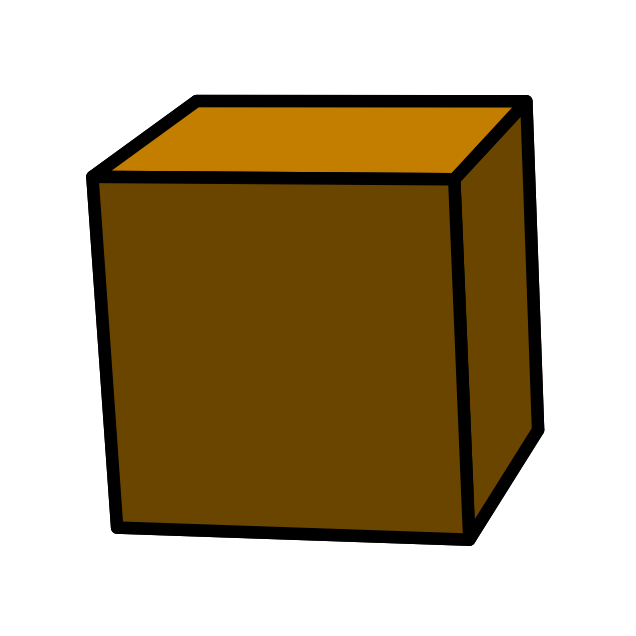

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Define the dimensions
size = 1

# Create a 3D grid of coordinates
x, y, z = np.indices((size, size, size))

# Create a 3D array to represent the cube (1s where the cube is, 0s elsewhere)
cube = (x < size) & (y < size) & (z < size)

# Plot the cube
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw the voxels
for i in range(size):
    for j in range(size):
        for k in range(size):
            if cube[i, j, k]:
                ax.bar3d(i, j, k, 1, 1, 1, color='orange', edgecolor='black', linewidth=9)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits
ax.set_xlim([0, size])
ax.set_ylim([0, size])
ax.set_zlim([0, size])


# Remove the grid and axis
ax.grid(False)
ax.axis('off')

# Set equal scaling for all axes to make the voxels look square
ax.set_box_aspect([1,1,1])

# Change the view angle
ax.view_init(elev=15, azim=15, roll = 3
             
            )

# Show the plot
plt.show()